Reference code:

[1] https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623

[2] https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

[3] https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0a862

[4] https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55


Dataloader: https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.io import imread, imsave
from torch.utils import data
from torch.utils.data import DataLoader
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.io import imread

In [2]:
from dataset import SegmentationDataSet 

In [3]:
raw_data_path = "data/raw/"
raw_data_paths = [raw_data_path+em for em in sorted(os.listdir(raw_data_path))]

labeled_data_path = "data/bin_true_membranes/"
labeled_data_paths = [labeled_data_path+em for em in sorted(os.listdir(labeled_data_path))]
labeled_data_paths.reverse()

In [4]:
pairs = {"raw": raw_data_paths, "label": labeled_data_paths}
pairs_df = pd.DataFrame(pairs)

In [5]:
def show_test_img(raw_path, label_path):
    raw = cv2.imread(raw_path)
    label = cv2.imread(label_path)
    dst = cv2.addWeighted(raw,0.5,label,0.5,0)
    plt.imshow(dst)

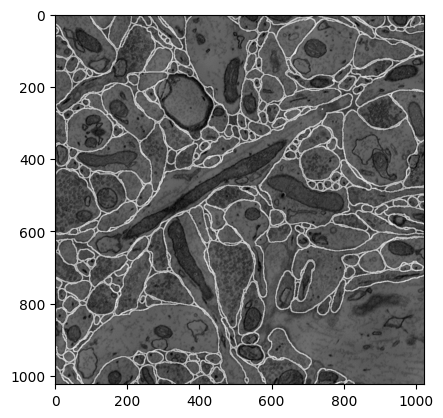

In [6]:
show_test_img(pairs_df.loc[10]["raw"], pairs_df.loc[10]["label"])

In [7]:
pairs_df.to_csv("data/membrane_dataset.csv")

In [8]:
dataset_len = pairs_df.shape[0]

Train test split will be 80% 20%

In [9]:
train_df = pairs_df[0:int(0.8*dataset_len)]
test_df = pairs_df[int(0.8*dataset_len):dataset_len]
train_df.to_csv("data/train_membrane_dataset.csv")
test_df.to_csv("data/train_membrane_dataset.csv")

In [10]:
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01


In [11]:
transforms = ComposeDouble([
    FunctionWrapperDouble(normalize_01, input=True, target=True)
])

In [12]:
training_dataset = SegmentationDataSet(inputs=train_df["raw"],
                                       targets=train_df["label"],
                                       transform=transforms)

test_dataset = SegmentationDataSet(inputs=test_df["raw"],
                                       targets=test_df["label"],
                                       transform=transforms)

In [13]:
dataloader_train = DataLoader(dataset=training_dataset,
                                 batch_size=2,
                                 shuffle=True)

dataloader_test = DataLoader(dataset=test_dataset,
                                   batch_size=2,
                                   shuffle=True)

In [14]:
x, y = next(iter(dataloader_train))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [16]:
from unet import UNet 

In [17]:
in_chan = 1
out_chan = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_chan, out_chan).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for images, masks in dataloader_train:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}')